# DANCE-MaP

## Recreation of adenine riboswitch DANCE-MaP analysis

Here I recreate the visualization done in Figure 2C of [Olson et. al. 2022](https://doi.org/10.1016/j.molcel.2022.02.009).

In short, DMS-MaP was performed on the *V. ful* adenine riboswitch IVT construct in an absence of adenine ligand. DANCE-MaP analysis recapitulates the known states and populations of this riboswitch and provides direct evidence of the known secondary and tertiary interactions. This data is then used to accurately model each state of the ensemble.

DanceMapper post-analysis files are availabe through the GEO (GSE182552). This is the direct download link: [GSE182552_RAW.tar](https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE182552&format=file). I extracted this folder and also the resulting folder, GSM5531266_wt_0_deep_danceoutput.tar.gz to obtain the Dancemapper output files. To predict structures from this data, I ran `python ~/DanceMapper/foldClusters.py --bp wt_0_deep wt_0_deep-reactivities.txt wt_0_deep` which produced .ct files. These .ct files were loaded into StructureEditor, which is part of [RNAstructure](http://rna.urmc.rochester.edu/RNAstructure.html). With this software, structure cassettes were removed and a custom layout for each secondary structure was created to match the original publication (wt_0_deep-0.nsd and wt_0_deep-1.nsd). Finally, the adenine-bound crystal structure was retreived from the PDB, [here](https://www.rcsb.org/structure/4TZX). This results in all 8 of the files needed for this analysis:
From PDB:
- 4tzx.pdb
From foldClusters.py followed by StructureEditor:
- wt_0_deep-0.nsd
- wt_0_deep-1.nsd
From original publication:
- wt_0_deep-0-pairmap.txt
- wt_0_deep-1-pairmap.txt
- wt_0_deep-0-rings.txt
- wt_0_deep-rings.txt
- wt_0_deep-reactivities.txt

## Import RNAvigate

The first step in this notebook is to import the RNAvigate python module.

In [1]:
import rnavigate as rnav

## Load data

DanceMapper outputs files have a standard naming convention: a sample prefix
followed by a suffix indicating the data type. We provide RNAvigate with the
sample prefix, and it will look for pairmap.txt, rings.txt and reactivities.txt
files.

Because the .nsd files are not part of the standard DanceMapper outputs, we
assign these manually. We do the same for the 4tzx.pdf ON state crystal
structure. Finally, we manually add a "span" annotation for the Shine-Delgarno
sequence.

In [2]:
sample = rnav.Sample(
    sample="V.vul adeRS",
    dance_prefix="wt_0_deep")

# replacing automatically generated sample names for each DANCE-MaP component
sample.dance[0].sample = "Translation OFF (58%)"
sample.dance[1].sample = "Translation ON (42%)"

# for each component of Dance, we are attaching additional data:
#     the .nsd structure drawing file
#     the 4tzx.pdb crystal structure
#     an annotation corresponding to the Shine-Delgarno sequence
for i in [0, 1]:
    sample.dance[i].set_data(name="ct", filepath=f"wt_0_deep-{i}.nsd")
    sample.dance[i].set_data(name="pdb", filepath="4tzx.pdb", chain="X")
    sample.dance[i].set_data(
        name="spans",
        seq_source="profile",
        span_list=[[99, 105]],
        color="DarkOrchid")

## Make Arc plot for each DANCE component

Olson et. al. established filters for visualizing RING-MaP and PAIR-MaP data that results from DANCE-MaP analysis. These filters are automated below with `sample.dance_filter()`.

A RING correlation between nucleotides i and j is included if:
- the correlation is positive and Gapc is above 23
- the contact distance between i and j is at least 15
- i and j are both single-stranded

PAIRs are included only if they agree with the predicted structure.

Then, rnav.plot_arcs_multisample() is used to create arc plots for each DANCE component. Arguments are explained in-line below.

c:\Users\psirv\anaconda3\envs\RNAvigate\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
c:\Users\psirv\anaconda3\envs\RNAvigate\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


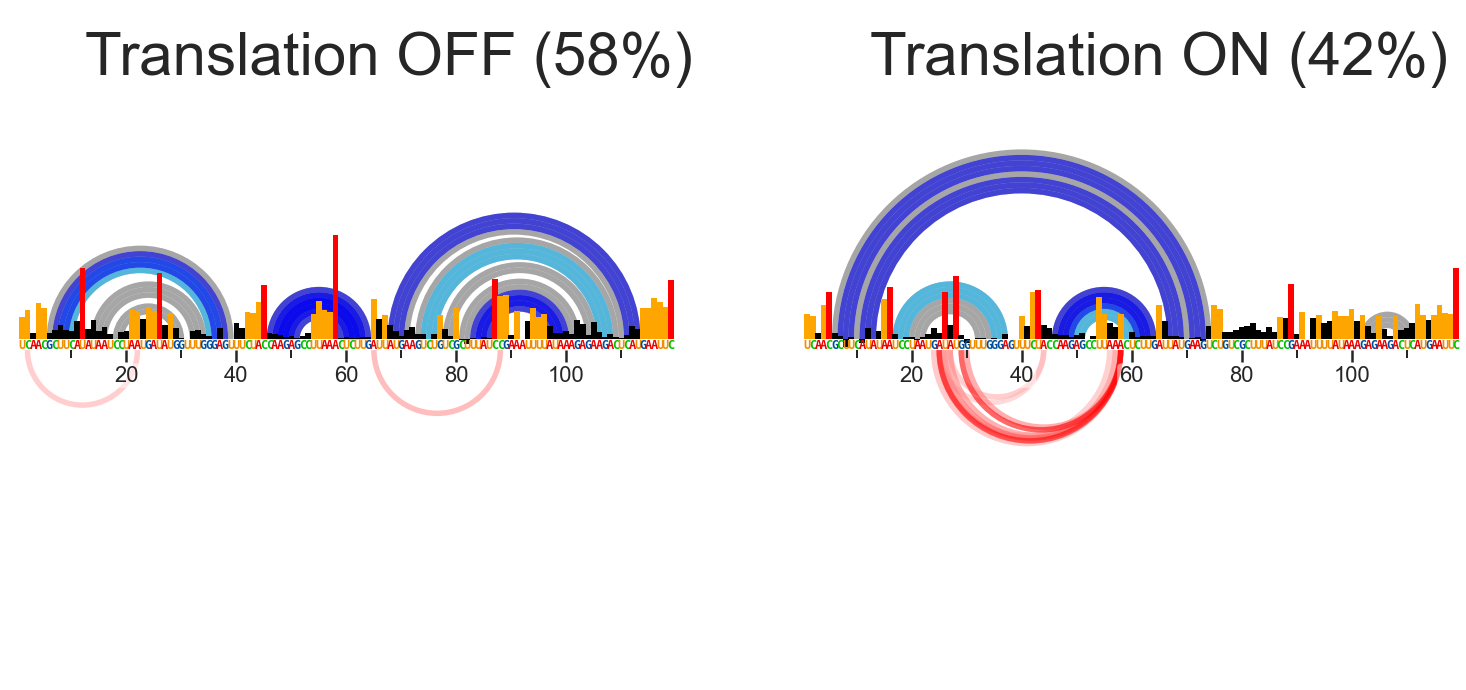

In [3]:
sample.dance_filter()
rnav.plot_arcs_multisample(
    samples=sample.dance,        # Make one plot per dance component
    interactions="pairmap",      # Plot PAIR-MaP data...
    interactions_panel="top",    # on the top panel
    interactions2="ringmap",     # Plot RING-MaP data (on bottom by default)
    prefiltered=True,            # Preserve the filtering applied above
    colorbar=False);             # Dont create a colorbar for RINGs/PAIRs

## Make secondary structure drawings for each component


Text(18, -10, 'SD')

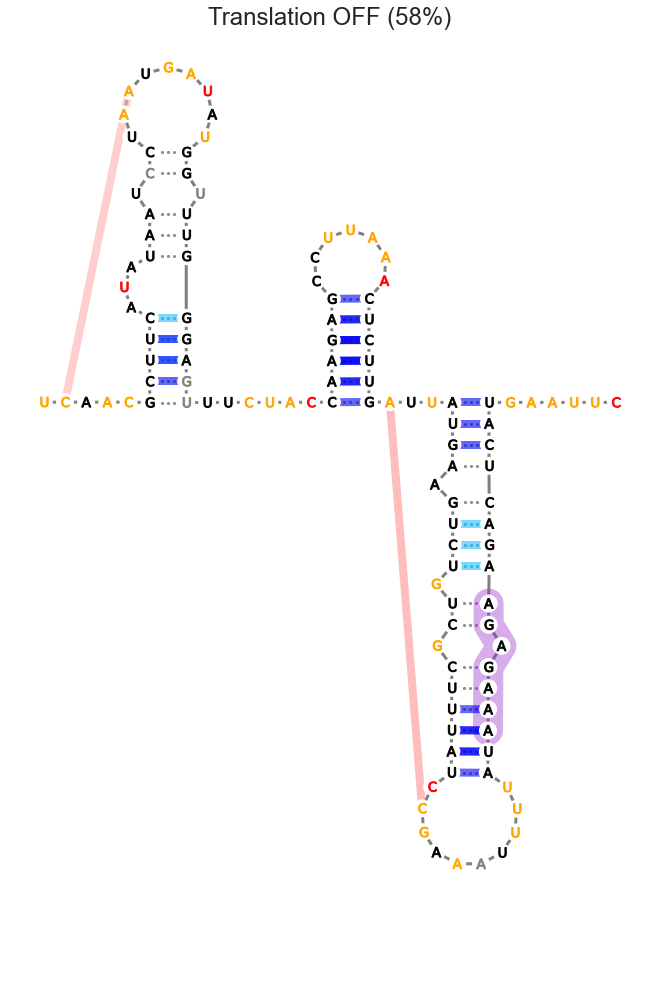

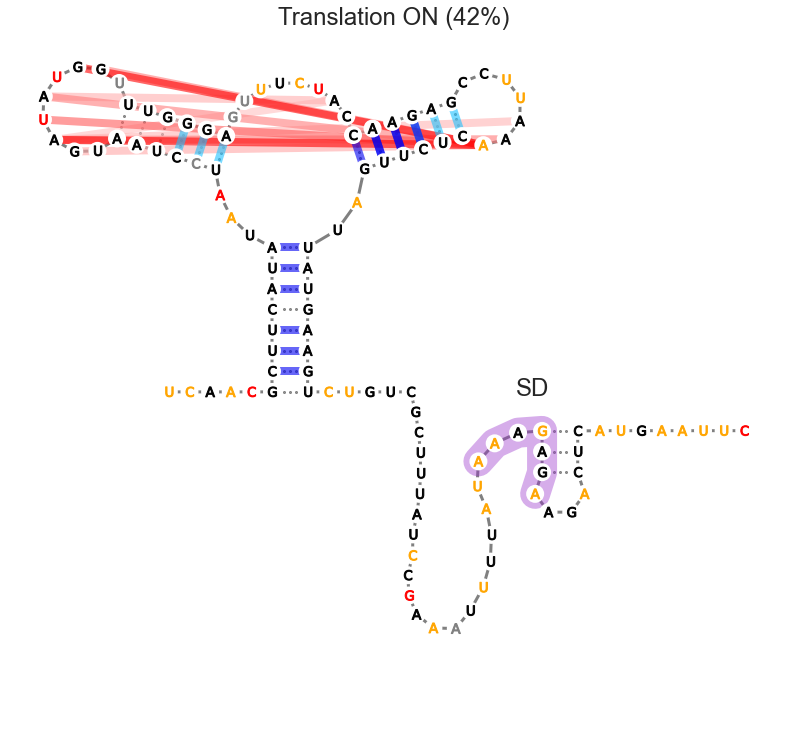

In [4]:
for component, (x, y) in zip(sample.dance, [[17,-20],[18,-10]]):
    plot = component.plot_ss(
        prefiltered=True,             # maintain the dance filter applied earlier
        ss="ct",                      # Use the structure drawing coordinates from the ct data
        annotations=["spans"],
        interactions2="pairmap",       # plot PAIR-MaP data
        interactions="ringmap",      # and RING-MaP data
        colors="profile",             # use shapemap reactivity colors
        apply_color_to="sequence",    # applied to the sequence letters
        colorbar=False,
        plot_kwargs={
            "data_lw":8,
            "data_z": 7,
        });              # Don't show color bars for RINGs and PAIRs data
plot.axes[0,0].text(x, y, 'SD')

## Draw 3D structure with RINGs

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

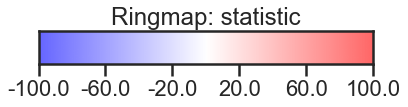

In [5]:
plot = sample.dance[1].plot_mol( # make a 3D rendering of the ON state
    interactions="ringmap",      # Draw RING-MaP data on structure
    interactions_filter={        # Requirements for filtering RING data:
        "Statistic_ge":23,         # Gapc greater than or equal to 23
        "ss_only": True,           # must be between single-stranded nucleotides
        "min_cd":15,               # minimum contact distance of 15
        "positive_only":True,      # positive correlations only
        "exclude_nts":[60]},       # remove spurious correlation at nucleotide 60
    atom="DMS",                  # Draw RING cylinders using atoms which react with DMS (N1 for A and C, N3 for U and G)
    nt_color="grey",              # Color RNA grey
    width=800, height=800,       # change plot dimensions
    background_alpha=0           # make background transparent
)